<a href="https://colab.research.google.com/github/Lenguist/insight-game-ai/blob/main/simple_sim_united.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Description moved to readme

# q learn

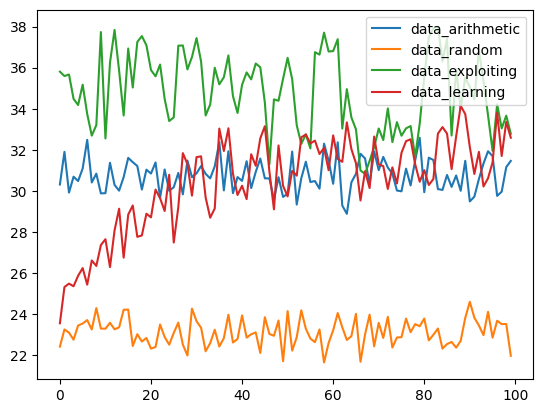

In [192]:
from buyer import Buyer
# params that are needed to initialize seller
value = 10
range_min = 11
range_max = 100
rounds = 1000
imp_incr = 0.01

init_offer=range_max

sellerQ = QLearningSeller(value=value, init_offer=init_offer)
sellerAri = DescentArithmeticSeller(value=value, init_offer=range_max,init_descent=(range_max-range_min)/3)
sellerRandom = RandomSeller(value=value,init_offer=init_offer)

rewards_learning = []
rewards_exploiting = []
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  imp_incr,
                            rounds = rounds,
                            seller=sellerQ,
                            verbose=False)
    rewards_learning.append(result)

sellerQ.set_exploiting()
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  imp_incr,
                            rounds = rounds,
                            seller=sellerQ,
                            verbose=False)
    rewards_exploiting.append(result)


rewards_descent_arithmetic = []
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr= imp_incr,
                            rounds = rounds,
                            seller=sellerAri,
                            verbose=False)
    rewards_descent_arithmetic.append(result)

rewards_random = []
for i in range(100):
    result = basic_simulation(value,
                            range_min,
                            range_max,
                            imp_incr=  imp_incr,
                            rounds = rounds,
                            seller=sellerRandom,
                            verbose=False)
    rewards_random.append(result)

import matplotlib.pyplot as plt

# your data
data_arithmetic = rewards_descent_arithmetic
data_learning = rewards_learning
data_exploiting = rewards_exploiting
data_random = rewards_random

# create a figure and axis
fig, ax = plt.subplots()

# plot the data
ax.plot(data_arithmetic, label = 'data_arithmetic')
ax.plot(data_random, label = 'data_random')
ax.plot(data_exploiting, label = 'data_exploiting')
ax.plot(data_learning, label = 'data_learning')

ax.legend()
# show the plot
plt.show()
